# Vehicle Detection - Project 4
This notebook contains the bulk of the processing required to detect vehicles in an road image pipeline.


In [259]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
import numpy as np
from scipy.ndimage.measurements import label
from sklearn.metrics import accuracy_score
import pickle
%matplotlib inline

# Loading the dataset
The dataset used for this project is provided by Udacity.
* [Vehicle datase](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* [Non vehicle dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

The dataset should be downlaoded, and all the files from each directory should be put in the "vehicle" and "non-vehicle" respective directories in the dataset folder.

In [113]:
vehicle_images = []
non_vehicle_images = []

for image_file in os.listdir("dataset/vehicles"):
    vehicle_images.append(plt.imread("dataset/vehicles/"+image_file))
    
    
for image_file in os.listdir("dataset/non-vehicles"):
    non_vehicle_images.append(plt.imread("dataset/non-vehicles/"+image_file))
    

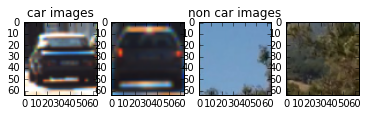

In [266]:
# plot sample image for verification
fig = plt.figure()
plt.subplot(141)
plt.imshow(vehicle_images[0])
plt.title('car images')
plt.subplot(142)
plt.imshow(vehicle_images[1])
plt.subplot(143)
plt.imshow(non_vehicle_images[0])
plt.title('non car images')
plt.subplot(144)
plt.imshow(non_vehicle_images[1])
plt.savefig("output_images/sample_begnning_images.jpg")

# Feature Extraction
In this section, we will extract the following features from each vehicle and non vehicle image:
* Histogram of gradients (HOG)
* Color features of the image
* Spatial features of the image
-----
### HOG
First we begin with the HOG features. Below is a function that takes a two dimensional array of pixels and returns the histogram of gradients, and also an optional image. Let's test it out.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


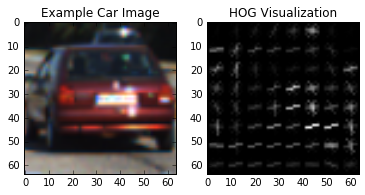

In [267]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, \
                                  cells_per_block=cell_per_block, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,\
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# choose a random car image
ind = np.random.randint(0, len(vehicle_images))
image = vehicle_images[ind]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = (8,8)
cell_per_block = (2,2)


hog_features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.savefig("output_images/hog.jpg")

### Spatial and color binning
Now for the two other features of our car photos: color and spatial binning. Here are these functions

In [216]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    i = 0
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        # apply spatial and color binning
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # apply HOG features       
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    
        # append the features
        features.append(np.hstack((spatial_features, hist_features, hog_features)))
    return features



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3
hist shape: (96,)
hog shape: (5292,)
spatial features: (3072,)
(8460,)
3
hist shape: (96,)
hog shape: (5292,)
spatial features: (3072,)
(8460,)


# Processing the dataset
Now that we have our feature extractors, let us process the data by extracting the features and normalizing them.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3
hist shape: (96,)
hog shape: (5292,)
spatial features: (3072,)
(8460,)
3
hist shape: (96,)
hog shape: (5292,)
spatial features: (3072,)
(8460,)


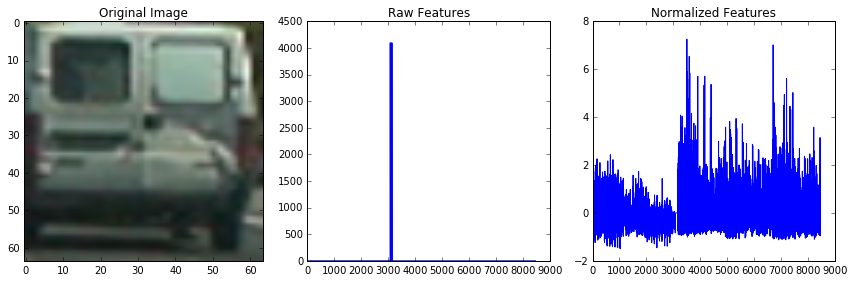

In [239]:
# lets put some parameters
spatial_size = (32,32)
histbin = 32
car_features = extract_features(vehicle_images, cspace='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(non_vehicle_images, cspace='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, hist_range=(0, 256))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(vehicle_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(vehicle_images[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
fig.savefig("output_images/normalization.pdf")

# Training the classifier
Now that we have the data available, we can train a classifier on them. We choose a linear SVM since it provides good accuracy and can train in a reasonable amount of time

In [241]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.4, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print("accuracy on test set:", accuracy_score(y_test, svc.predict(X_test)))

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
36.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9877
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.01866 Seconds to predict 10 labels with SVC
accuracy on test set: 0.987716179085


### Storing the classifier
After being content with the classifier we have, let's save it!

In [264]:
with open("svc.pickle", "wb") as f:
    pickle.dump(svc, f)
with open("scaler.pickle", "wb") as f:
    pickle.dump(X_scaler, f)

# Finding cars in images
Now that we have a proper classifier with a great accuracy score, let's create the pipeeline required to find similar car images in a larger context of the road. First we will need some sample images with and without cars.

In [205]:
test_images = [plt.imread("test_images/"+test_image_file) for test_image_file in os.listdir("test_images")
               if test_image_file[-4:]=='.jpg']

Now, let us build a function that can find cars and draw boxes around them!

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


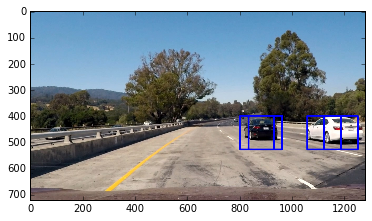

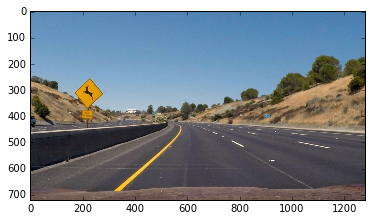

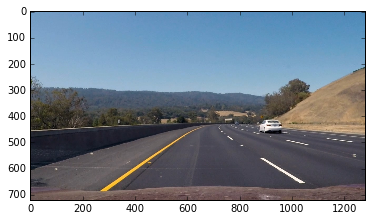

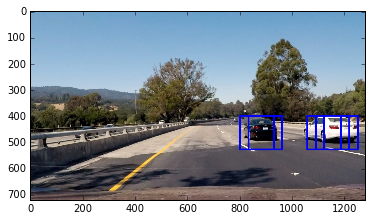

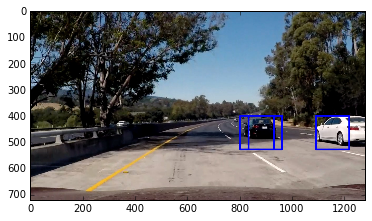

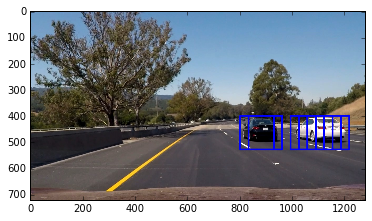

In [270]:
# A simple function to conver the color space of the images
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell[0]) - cell_per_block[0] + 1
    nyblocks = (ch1.shape[0] // pix_per_cell[0]) - cell_per_block[0] + 1 
    nfeat_per_block = orient*cell_per_block[0]**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell[0]) - cell_per_block[0] + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            

            xleft = xpos*pix_per_cell[0]
            ytop = ypos*pix_per_cell[0]

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 2

for test_image in test_images:
    out_img = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin)
    plt.figure()
    plt.imshow(out_img)
    plt.savefig("output_images/sliding_window.jpg")

# Removing redundancies --> heat maps
We notice that each car has more than one box on it, a side effect of the sliding windows approach. To fix this, we apply a heat map that will allow us to score regions in the image based on how many boxes are in them and box only such areas.


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


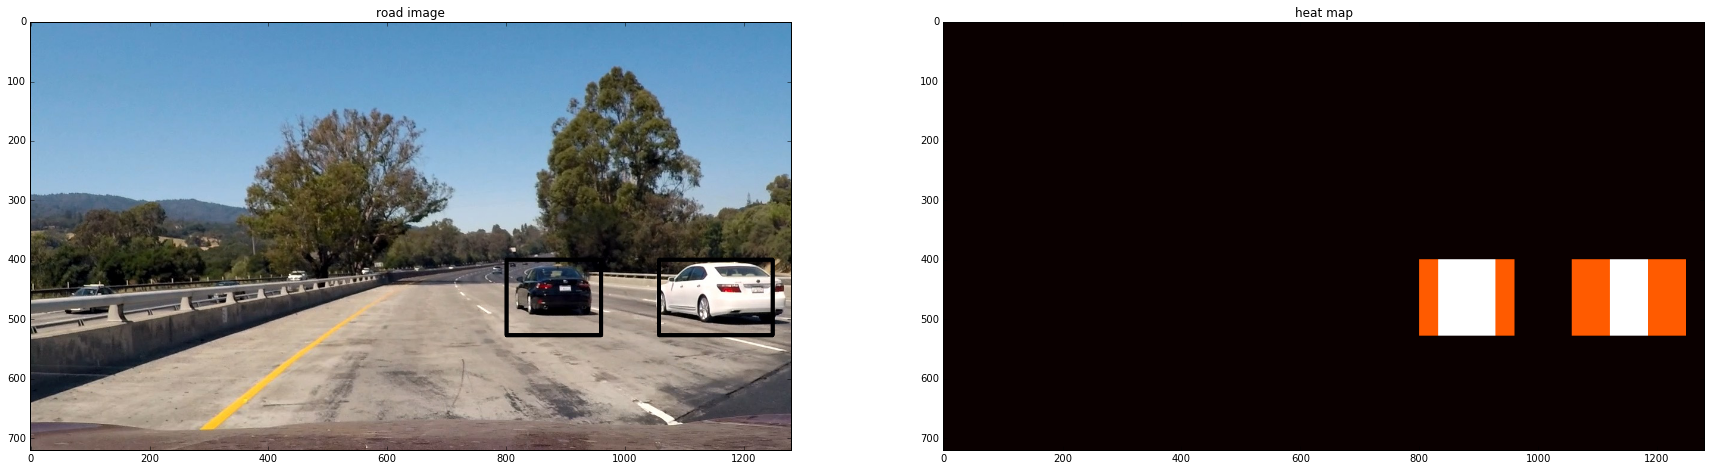

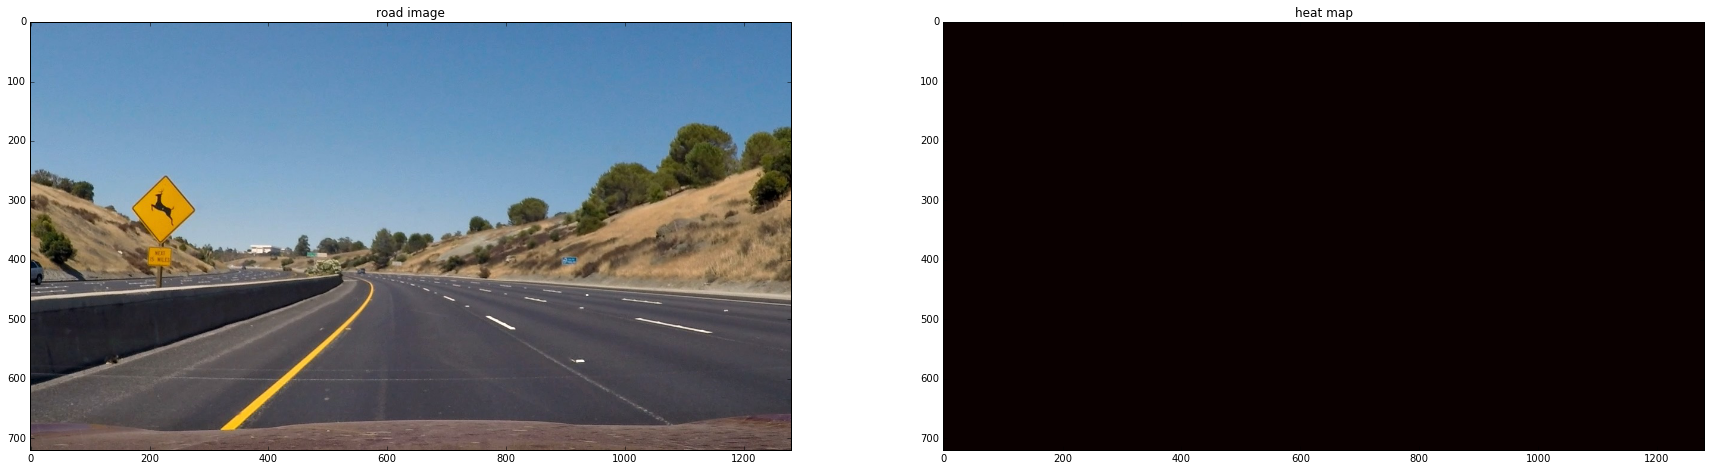

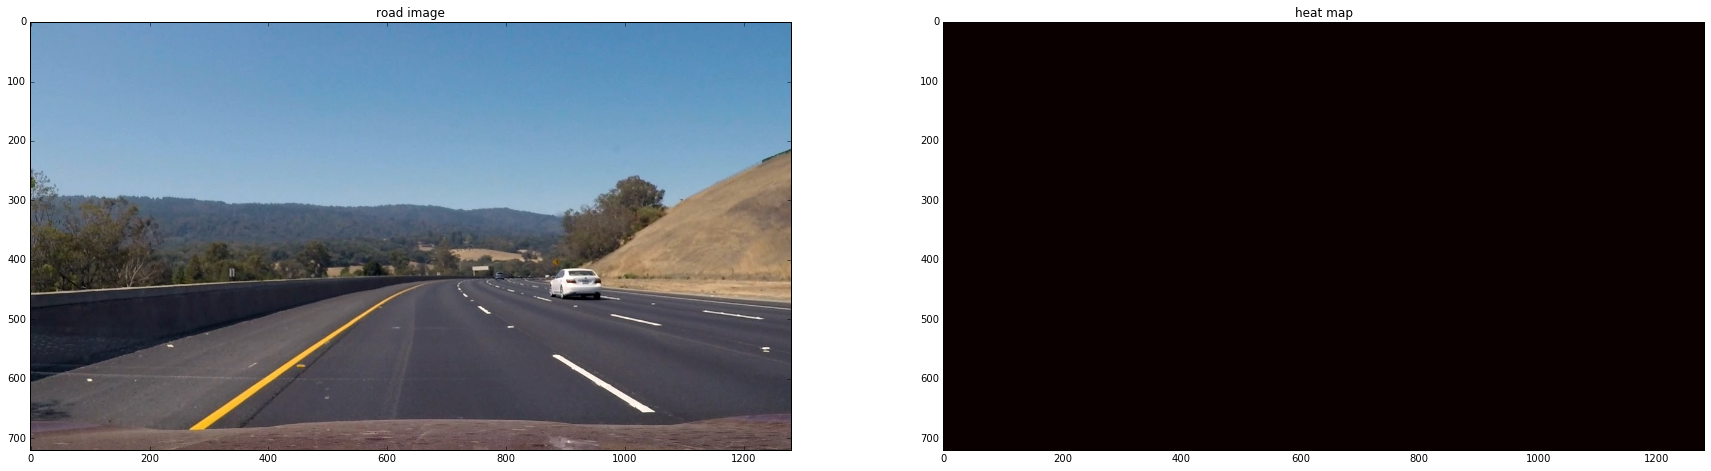

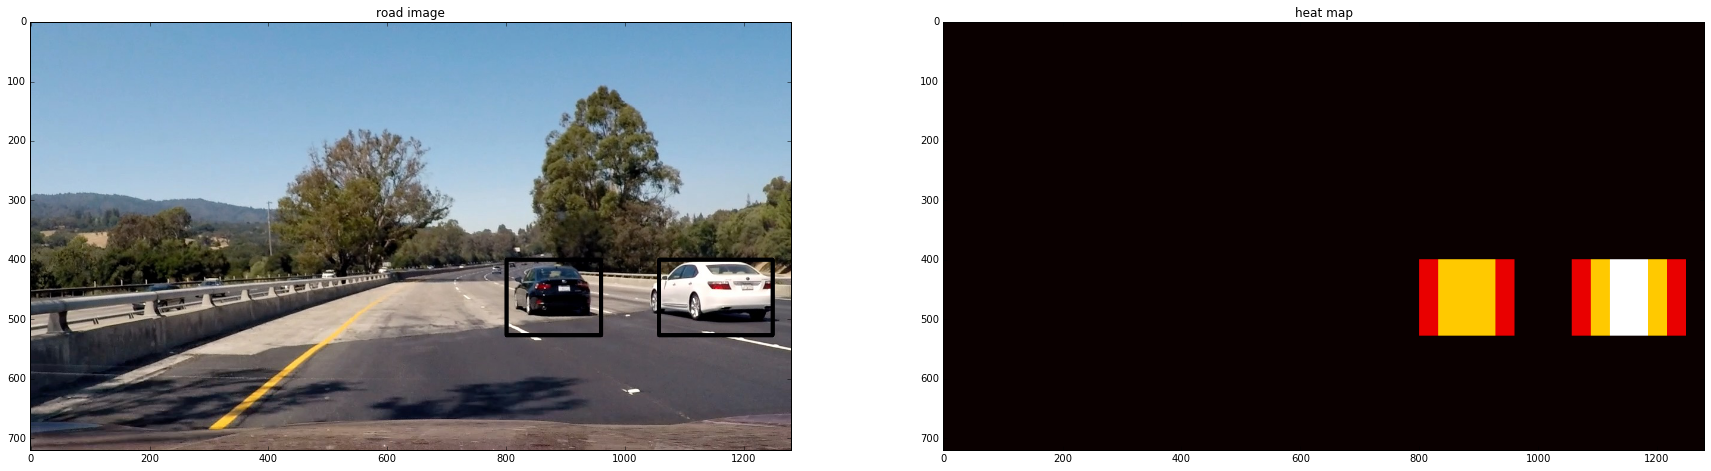

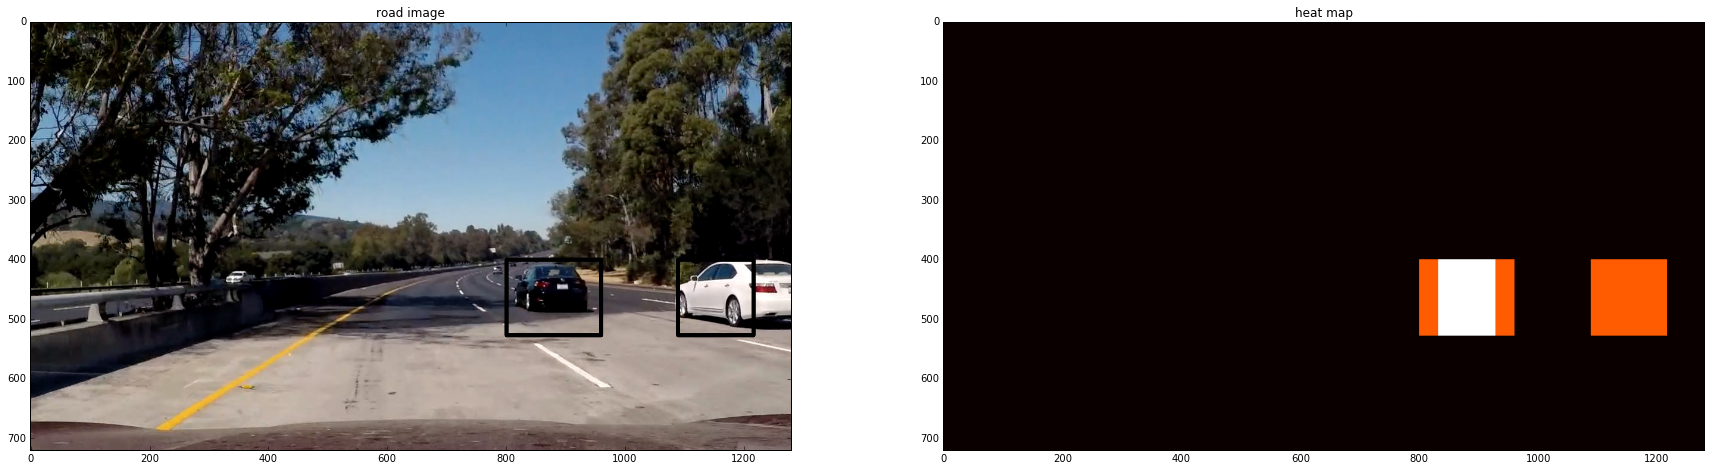

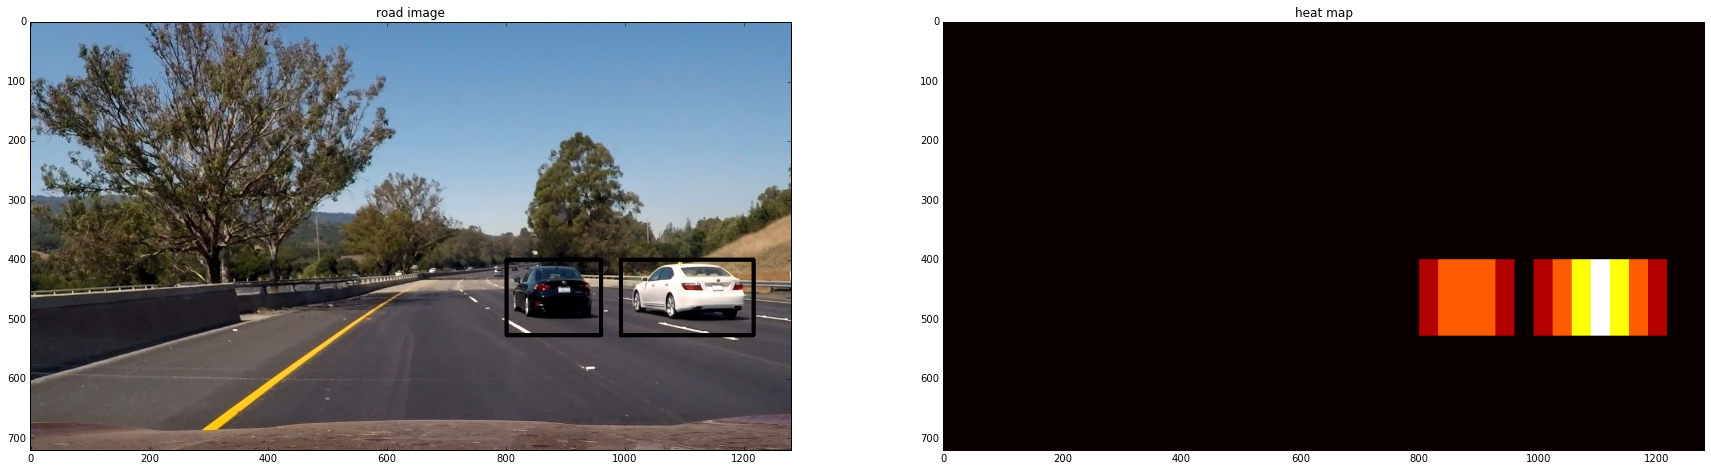

In [274]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell[0]) - cell_per_block[0] + 1
    nyblocks = (ch1.shape[0] // pix_per_cell[0]) - cell_per_block[0] + 1 
    nfeat_per_block = orient*cell_per_block[0]**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell[0]) - cell_per_block[0] + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell[0]
            ytop = ypos*pix_per_cell[0]

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
                
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img, heatmap, labels
    
ystart = 400
ystop = 656
scale = 2

i = 1
for test_image in test_images:
    out_img, heatmap, a  = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin)
    fig = plt.figure(figsize=(30,15))
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title("road image")
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title("heat map")
    plt.savefig("output_images/heatmap"+str(i)+".jpg")
    i+=1
